In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Activation Functions

## Softmax Function

$$y_k=\frac{\text{exp}(a_k)}{\sum_{i=1}^n \text{exp}(a_i)} \tag{3.10}$$

In [80]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

a = np.array([.3, 2.9, 4.0])
print(softmax(a))
print(np.sum(softmax(a)))

[0.01821127 0.24519181 0.73659691]
1.0


## Overflow Problem  
If $e^x$ is greater than a computer's computation limit, it cannot compute or store the value. Thus we can use the following scaling method:
$$\begin{align*}
y_k=\frac{\text{exp}(a_k)}{\sum_{i=1}^n \text{exp}(a_i)}
&= \frac{C\text{exp}(a_k)}{C\sum_{i=1}^n \text{exp}(a_i)}\\
&= \frac{\text{exp}(a_k+\log C)}{\sum_{i=1}^n \text{exp}(a_i+\log C)}\\
&= \frac{\text{exp}(a_k) + \log C'}{\sum_{i=1}^n \text{exp}(a_i + \log C')} \tag{3.11}
\end{align*}$$

In [83]:
# Problem Situation

a = np.array([1010, 1000, 990])
print(softmax(a))

c = np.max(a) # 1010
print(a-c)

# scaled
print(np.exp(a-c) / np.sum(np.exp(a-c)))

[nan nan nan]
[  0 -10 -20]
[9.99954600e-01 4.53978686e-05 2.06106005e-09]


/var/folders/9z/ptnmmp057j10fhyq19vxk38c0000gn/T/ipykernel_84692/3218730526.py:2: RuntimeWarning: overflow encountered in exp
  exp_a = np.exp(a)
/var/folders/9z/ptnmmp057j10fhyq19vxk38c0000gn/T/ipykernel_84692/3218730526.py:4: RuntimeWarning: invalid value encountered in divide
  y = exp_a / sum_exp_a


In [ ]:
def softmax(a): # Overflow Problem Resolved Version
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

## Sigmoid Function
$$f(x)=\frac{1}{1+\exp^x}$$

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Cross Entropy
훈련 데이터 모두에 대한 교차 엔트로피 오차는 $$-\frac{1}{N}\sum_n \sum_k t_{n_k}\log y_{n_k}$$이다. 그런데 실제 데이터는 데이터의 개수가 수백만, 혹은 그 이상인 경우가 많으므로, 이렇게 매번 모든 데이터에 대한 오차를 구하려면 시간이 너무 오래걸린다. 따라서 훈련 데이터 중 일부만 골라 학습을 진행하고, 이 일부를 **미니배치**(mini-batch)라고 부른다. 또 이러한 학습 방법을 **미니배치 학습**이라 부른다.

```python
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), np.int32(t)] + 1e-7)) / batch_size
```

In [ ]:
def cee_batch(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size
'''
If y is 1D, reshape y and t.
Normalize CEE value by dividing with "batch_size".
This function is for the case where the answer label (t) is one-hot encoded.
If not, use the following one:
'''

def cee_batch(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
'''
np.arange(batch_size): 0 ~ batch_size-1
Since t is like [2, 7, 0, 9, 4] (answer),
y[np.arange(batch_size), t] returns the output of the NN corresponding to the answer label.
e.g. [y[0,2], y[1,7], y[2,0], y[3,9], y[4,4]]
This is possible as, if t == 0, CEE == 0; i.e., y[0,i] == 0 (i != 2). 
'''

# Gradient Computation

미분을 수행하기 위해 $$\lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$를 하는 것은 불가능하다. 따라서 h를 **1e-50**와 같은 아주 작은 수로 설정하는 방법이 있다. 그러나 사실 위와 같이 작은 h는 사실상 0으로 처리된다. 따라서 위와 같은 방법은 불가능하다.
```python
>>> np.float32(1e-50) == 0
True
```

그렇기 때문에 h의 크기를 줄이고, 중심 차분이라는 방법을 이용한다.
$$f'(x)\simeq\frac{f(x+h)-f(x-h)}{2h}$$

In [4]:
def f(x):
    return x[0]**2 + x[1]**2

def numerical_gradient_no_batch(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # Restore the value

    return grad

def numerical_gradient(f, x):
    if x.ndim == 1: # Case 1: x is a single data point
        return numerical_gradient_no_batch(f, x)
    else: # Case 2: x is a numpy array
        grad = np.zeros_like(x)
        for idx, x in enumerate(x):
            grad[idx] = numerical_gradient_no_batch(f, x)
        return grad

In [5]:
print(numerical_gradient(f, np.array([3.0, 4.0]))) # Gradient at (3,4)
print(numerical_gradient(f, np.array([0.0, 2.0]))) # Gradient at (0,2)
print(numerical_gradient(f, np.array([3.0, 0.0]))) # Gradient at (3,0)

[6. 8.]
[0. 4.]
[6. 0.]


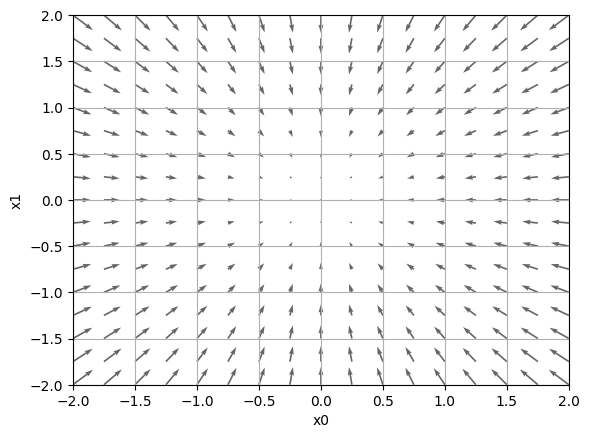

In [6]:
# Gradient Plot

def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()

# Gradient Descent Method
$$x_i = x_i - \eta \frac{\partial f}{\partial x_i}$$

In [7]:
def gradient_descent(f, init_x, lr=.01, step_num=100):
    x = init_x
    x_histroy = []

    for i in range(step_num):
        x_histroy.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x, np.array(x_histroy)

init_x = np.array([-3.0, -4.0]) # Initial Value
print(gradient_descent(function_2, init_x=init_x, lr=.1, step_num=100)[0])

[-6.11110793e-10 -8.14814391e-10]


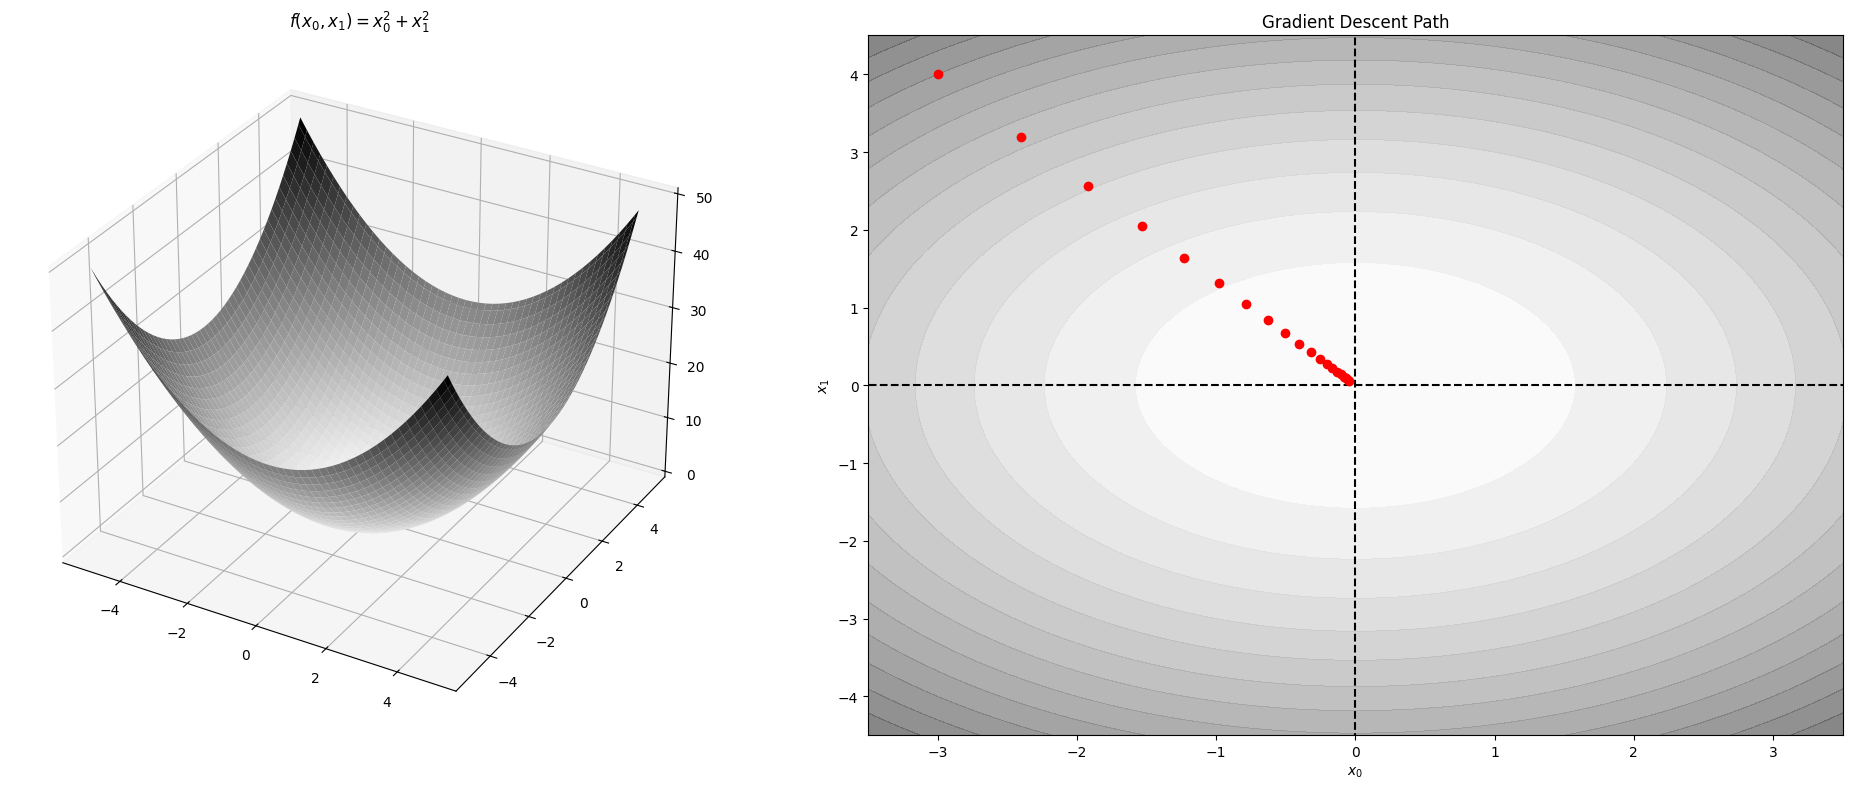

In [8]:
fig = plt.figure(figsize=(20, 8))

# First panel
ax1 = fig.add_subplot(121, projection='3d')
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
x_m, y_m = np.meshgrid(x, y)
z = x_m**2 + y_m**2
ax1.plot_surface(x_m, y_m, z, cmap='binary')
ax1.set_title(f'$f(x_0,x_1)=x_0^2+x_1^2$')

# Second panel
init_x = np.array([-3.0, 4.0])
lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x=init_x, lr=lr, step_num=step_num)

ax2 = fig.add_subplot(122)
ax2.contourf(x_m, y_m, z, levels=20, cmap='binary', alpha=0.75)
ax2.plot([-5, 5], [0, 0], '--k')
ax2.plot([0, 0], [-5, 5], '--k')
ax2.plot(x_history[:,0], x_history[:,1], 'or')
ax2.set_xlim(-3.5, 3.5)
ax2.set_ylim(-4.5, 4.5)
ax2.set_xlabel(f"$x_0$")
ax2.set_ylabel(f"$x_1$")
ax2.set_title('Gradient Descent Path')

plt.tight_layout()
plt.show()

## Gradient Descent in NN

In [9]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from functions import softmax, cross_entropy_error
from gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # Initialize with Gaussian
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [10]:
net = simpleNet()
print(f"net.W:\n{net.W}\n")

x = np.array([.6, .9])
p = net.predict(x)
print(f"p: {p}\n")

print(f"np.argmax(p): {np.argmax(p)}\n")
t = np.array([0, 0, 1]) # answer
print(f"net.loss(x, t): {net.loss(x, t)}")

net.W:
[[-0.27783942 -1.25861042  0.78081106]
 [ 2.16847607  0.85760692  0.51440136]]

p: [1.78492481 0.01667998 0.93144786]

np.argmax(p): 0

net.loss(x, t): 1.32133016267954


In [11]:
def f(W):
    return net.loss(x, t)
# or f = lambda w: net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.37580699  0.06412478 -0.43993177]
 [ 0.56371049  0.09618717 -0.65989766]]


즉, dW[0,0]이 0.2라면, w_11이 h만큼 증가할 때 loss L이 0.2h만큼 증가한다는 뜻.  
따라서 w_11은 음의 방향으로 갱신해야 할 것임. 나머지 w 값들도 마찬가지.

# Implementation
1. Pick mini-batch
2. Compute Gradient
3. Update $W$
4. Repeat 1~3

The method here updating $W$ with the gradient descent method is called **Stochastic Gradient Descent** since it uses randomly picked mini-batch.

**2층 신경망 구현하기 (은닉층이 1개인 네트워크)**  
- input_size: n(neurons) of input layer  
- hidden_size: n(neurons) of hidden layer
- output_size: n(neurons) of output layer

In [12]:
import sys, os
sys.path.append(os.pardir)
from functions import *
from gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = .01):
        # Initialize Weights
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y
    
    # x: input data, t: answer label
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [13]:
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch) # Forward Propagation
    grad = network.gradient(x_batch, t_batch) # Backward Propagation
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.78665, 0.7947
train acc, test acc | 0.87565, 0.8804
train acc, test acc | 0.8988833333333334, 0.8991
train acc, test acc | 0.9092666666666667, 0.9111
train acc, test acc | 0.9152833333333333, 0.9178
train acc, test acc | 0.91965, 0.9226
train acc, test acc | 0.92455, 0.926
train acc, test acc | 0.9291666666666667, 0.9302
train acc, test acc | 0.9312666666666667, 0.9322
train acc, test acc | 0.9341333333333334, 0.9337
train acc, test acc | 0.9374333333333333, 0.9372
train acc, test acc | 0.9393166666666667, 0.9391
train acc, test acc | 0.9409833333333333, 0.9405
train acc, test acc | 0.9432833333333334, 0.9421
train acc, test acc | 0.9458833333333333, 0.9436
train acc, test acc | 0.9473166666666667, 0.9451


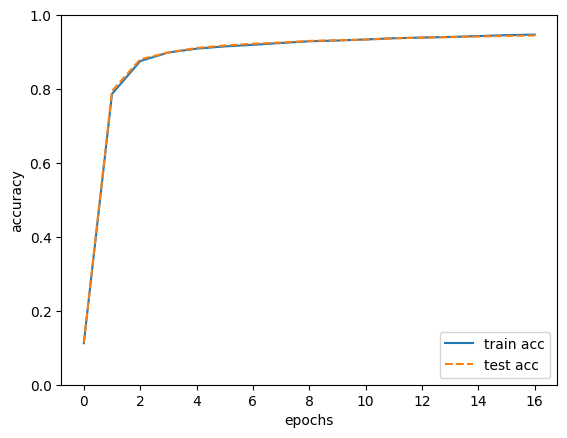

In [14]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

0th result: True. Prediction: 7
1th result: True. Prediction: 2
2th result: True. Prediction: 1
3th result: True. Prediction: 0
4th result: True. Prediction: 4


5th result: True. Prediction: 1
6th result: True. Prediction: 4
7th result: True. Prediction: 9
8th result: False. Prediction: 6. Answer: 5
9th result: True. Prediction: 9




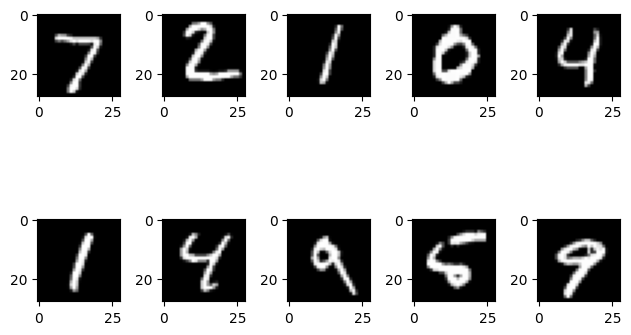

In [15]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    result = np.argmax(network.predict(x_test[i])) == np.argmax(t_test[i])
    a = i//5; b = i % 5
    # print(result)
    if result == True:
        print(f"{i}th result: True. Prediction: {np.argmax(network.predict(x_test[i]))}")
    else: print(f"{i}th result: False. Prediction: {np.argmax(network.predict(x_test[i]))}. Answer: {np.argmax(t_test[i])}")
    if i % 5 == 4:
        print("\n")
    ax[a,b].imshow(x_test[i].reshape((28,28)), cmap='gray')

plt.tight_layout()
plt.show()